# OptimUS validation
The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers with boundary element methods. This notebook demostrates the accuracy of the OptimUS library by comparing its solutions with the analytical expression for scattering at a sphere.


## Analytical Solution

We consider a sphere $\Omega^{-} \in \mathbb{R}^3$ of radius $R$, let $\Gamma$ be its boundary and $\Omega^{+}$ be the exterior. The transmission problem for the Helmholtz scalar acoustic equation is given by
$$
\begin{aligned}
    \nabla^2 u^t + (\kappa^{\pm})^2 u^t &= 0 &&,\text{ in } \Omega^{\pm}\\
    u^{+} &= u^{-} &&,\text{ in } \Gamma\\
    \frac{1}{\rho^{+}} \partial_{\nu} u^{+} &= \frac{1}{\rho^{-}} \partial_{\nu} u^{-} &&, \text{ in } \Gamma
\end{aligned}
$$
where $\kappa^{\pm}$ and $\rho^{\pm}$ are the wave number and material density in $\Omega^{\pm}$, respectively. $u_t$ is the total pressure field in $\mathbb{R}^3$ and $u^{\pm}$ denote the pressure fields in the exterior and interior domains, respectively. Furthermore, $\partial_{\nu}$ is the normal derivative operator.

Let $\vec{d}$ be a unit vector. The pressure field for the incident plane wave in the direction of $\vec{d}$ is given by $u^i(\vec{x}) = e^{\textrm{i} \kappa_{+} \vec{x}\cdot \vec{d}}$. 
We consider $u^{+} = u^i + u^s$ be the total pressure field in the exterior domain, where $u^s$ is the scattered pressure field satisfying the Sommerfeld radiation condition and is given by
$$
    u^s(\vec{x}) = \sum_{n=0}^{\infty} a_n h^{(1)}_{n}(\kappa_{+} \lVert{\vec{x}} \rVert) P_n(\hat{x}\cdot\vec{d})
    \hspace{1cm}
    \hat{x} = \vec{x} / \lVert \vec{x} \rVert
$$
where $h^{(1)}_n = j_n + \textrm{i} y_n$ is the spherical Hankel function of the first kind of order $n$ and $P_n$ is the Legendre polynomial of order $n$. The coefficient $a_n$ for each $n$ is given by
$$
    a_{n}
    =
    \frac
    {%
        (2n+1) \textrm{i}^n
        \left[
            j_n(\kappa^{+} R)
            j'_{n}(\kappa^{-} R)
            -
            \rho \kappa
            j_{n}(\kappa^{-} R)
            j'_{n}(\kappa^{+} R)
        \right]
    }
    {%
        \rho \kappa
        j_{n}(\kappa^{-} R)
        h'^{(1)}_{n}(\kappa^{+} R)
        -
        j'_{n}(\kappa^{-} R)
        h^{(1)}_{n}(\kappa^{+} R)
    },
$$
where $\rho = \rho^{-}/\rho^{+}$ and $\kappa = \kappa^{+}/\kappa^{-}$.

On the other hand, the interior wave $u^{-}$ is given by
$$
    u^{-}(\vec{x}) = \sum_{n=0}^{\infty} b_n j_{n}(k^{-} \lVert \vec{x} \rVert) P_n(\hat{x}\cdot \vec{d})
$$
where the coefficients are written in terms of the $a_n$ described above
$$
    b_n = \frac{(2n + 1) \textrm{i}^n j_n(k^{+} R) + a_{n} h^{(1)}_{n} (\kappa^{+} R)}{j_{n}(\kappa^{-} R)}.
$$

## Comparison

We import the OptimUS library and set up the basic parameters for the simulation.

In [2]:
import optimus

In [3]:
frequency = 1000
source = optimus.source.create_planewave(frequency, direction=(1,1,0))

In [4]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

We specify some visualization parameters as well

In [5]:
bounding_box = [-3, 5, -3, 4]
plane_axes = (0,1)
resolution = (250,250)

Now we compute both models as well as the visualization plane. For the analytical model, the number of expansion terms can be specified by the parameter `n_iter` in the `solve` method.

In [6]:
planes = list()
elem_sizes = [1.0, 0.75, 0.5, 0.25, 0.1]
for element_size in elem_sizes:
    geometry = optimus.geometry.shapes.Sphere(element_size=element_size)
    
    # Build and solve analytical model
    analytical_model = optimus.model.acoustics.Analytical(source, geometry, material_ext, material_int)
    analytical_model.solve(n_iter=100)
    
    # Build and solve bem model
    bem_model = optimus.model.acoustics.Pmchwt(source, geometry, material_ext, material_int, "mass")
    bem_model.solve()
    
    # Compute analytical fields in the plane plane_axes
    analytical_plane = optimus.postprocess.VisualisePlane(analytical_model)
    analytical_plane.create_computational_grid(
        resolution=resolution,
        bounding_box=bounding_box,
        plane_axes=plane_axes
    )
    analytical_plane.compute_fields()
    
    # Compute bem fields in the plane plane_axes
    bem_plane = optimus.postprocess.VisualisePlane(bem_model)
    bem_plane.create_computational_grid(
        resolution=resolution,
        bounding_box=bounding_box,
        plane_axes=plane_axes
    )
    bem_plane.compute_fields()
    
    # Save visualization planes for future inspections and comparison
    planes.append( (analytical_plane, bem_plane) )

With the planes computed, we can calculate the relative error in both Frobenius and maximum norm.

In [7]:
import numpy as np
from numpy.linalg import norm

In [8]:
frob_rel_error_list = list()
unif_rel_error_list = list()


for (analytical_plane, bem_plane) in map(
    lambda p: (np.real(p[0].total_field_imshow), np.real(p[1].total_field_imshow)),
    planes
):
    diff = np.nan_to_num(analytical_plane - bem_plane)
    
    # Compute frobenius relative error
    frob_rel_error = norm(diff, 'fro') / norm(np.nan_to_num(analytical_plane), 'fro')
    frob_rel_error_list.append(frob_rel_error)
    
    # Compute uniform relative error
    unif_rel_error = norm(diff, np.inf) / norm(np.nan_to_num(analytical_plane), np.inf)
    unif_rel_error_list.append(unif_rel_error)

Now we plot the relative errors against the element size

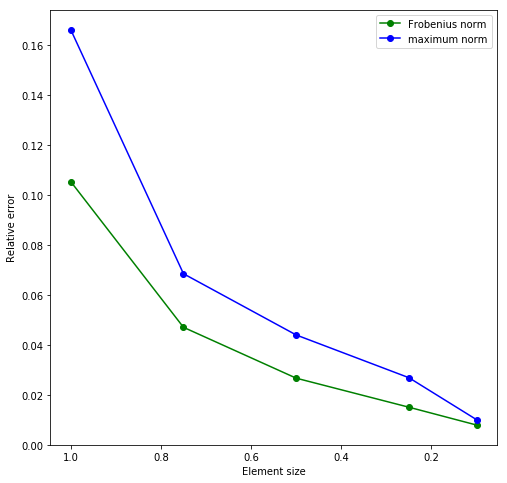

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(8,8))

plt.plot(elem_sizes, frob_rel_error_list, 'go-', label='Frobenius norm')
plt.plot(elem_sizes, unif_rel_error_list, 'bo-', label='maximum norm')

plt.legend()
plt.xlabel('Element size')
plt.ylabel('Relative error')

plt.gca().invert_xaxis()

plt.show()

We now plot the field side by side for visual inspection.

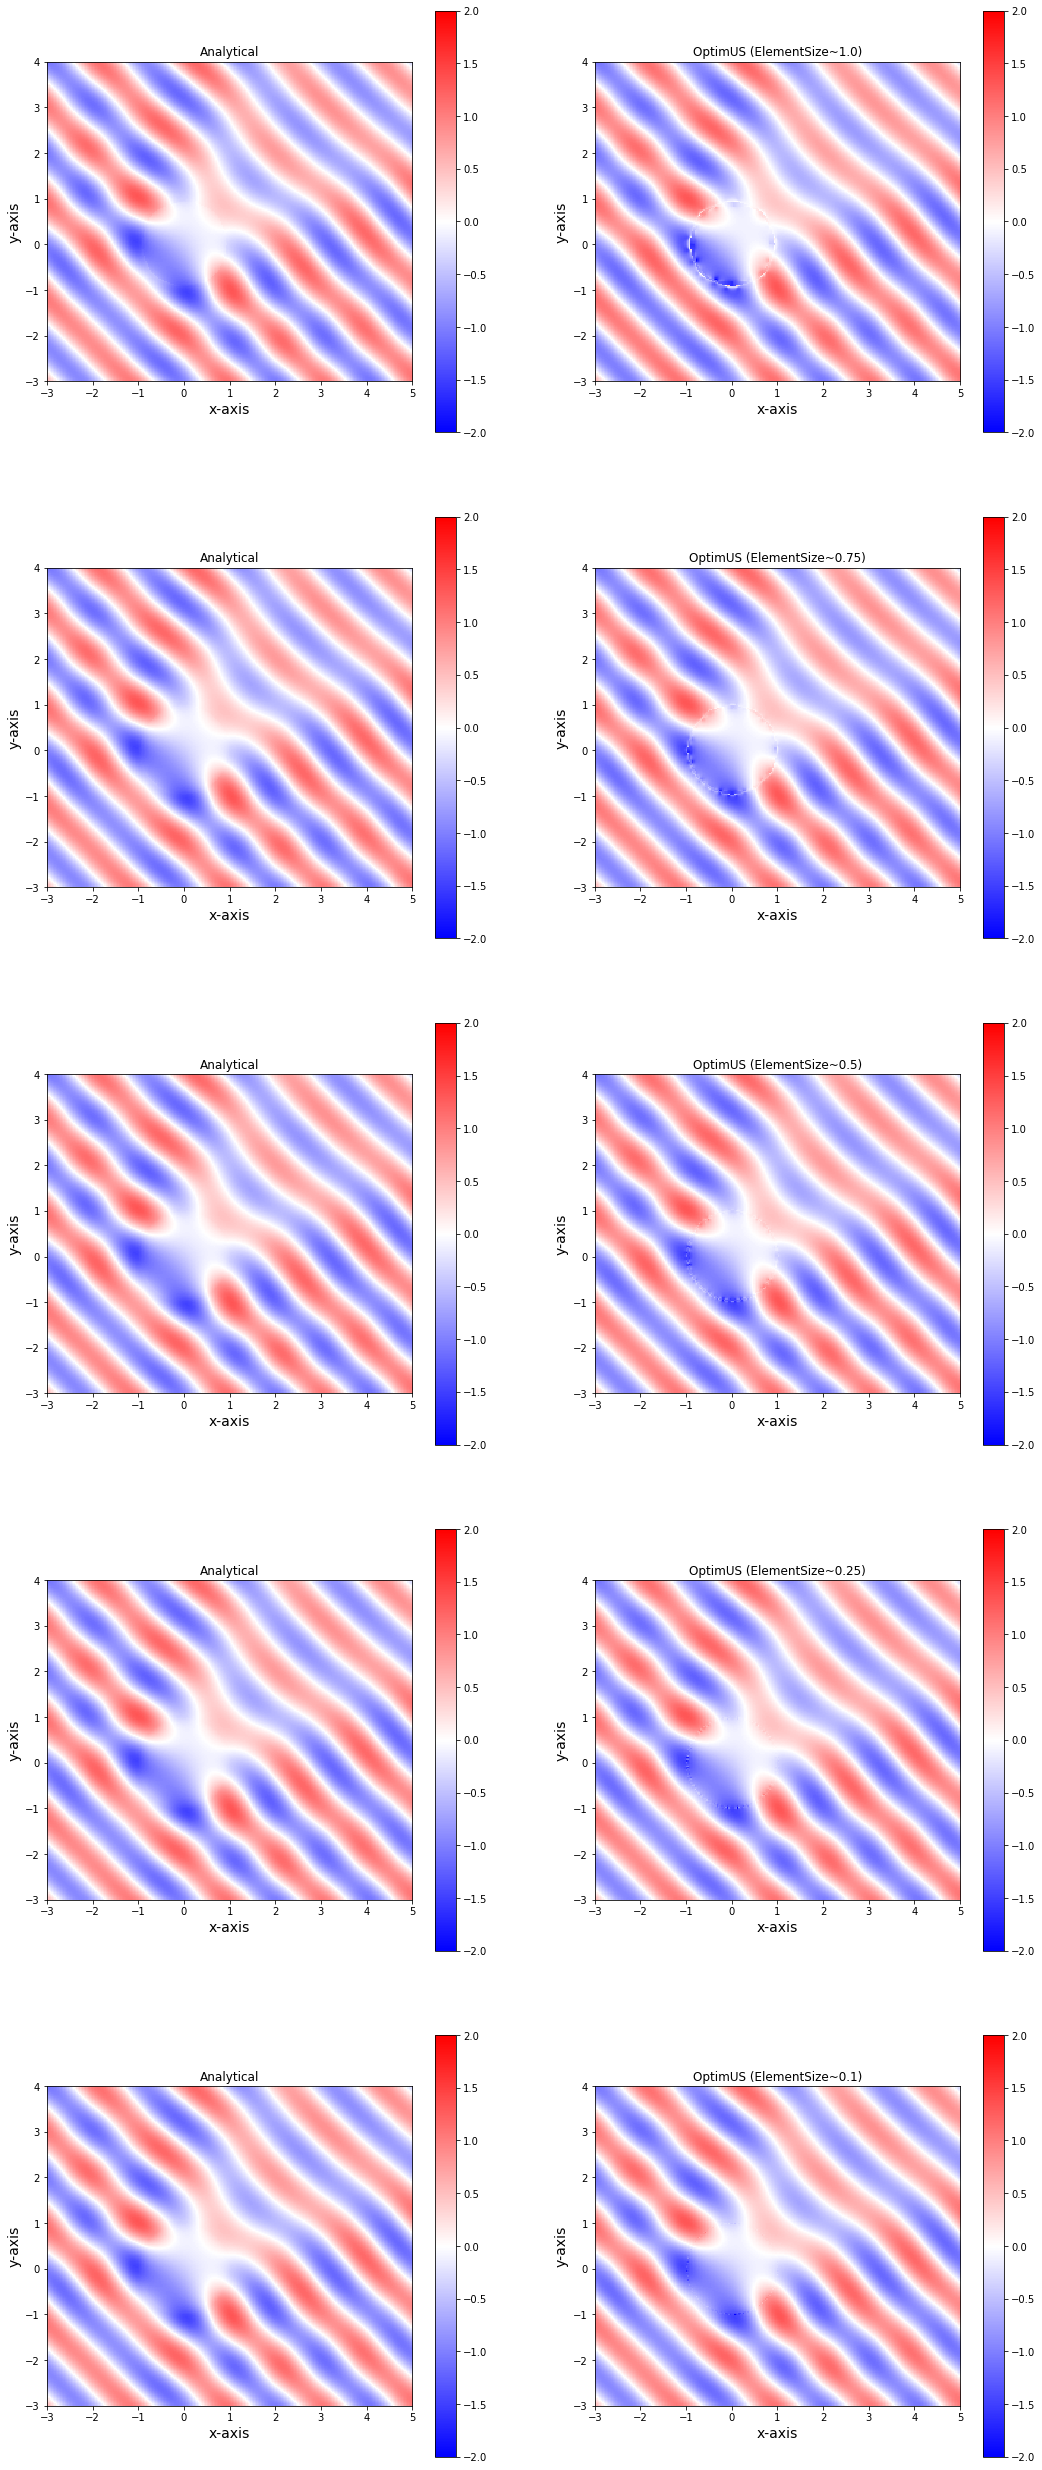

In [11]:
ncols = 2
nrows = len(elem_sizes)

axs = (plt.figure(figsize=(9 * ncols, 9 * nrows)).subplots(nrows=nrows, ncols=2))

plt_info = [
    (
        (axs[i][0], "Analytical", np.real(planes[i][0].total_field_imshow)),
        (axs[i][1], "OptimUS (ElementSize~" + str(n) + ")", np.real(planes[i][1].total_field_imshow))
    )
    for i, n in enumerate(elem_sizes)
]

axis_label = 'xyz'

for each_row in plt_info:
    for (ax, title, data) in each_row:
        ax.set_title(title)
        ax.set_xlabel(axis_label[plane_axes[0]] + '-axis', size='14')
        ax.set_ylabel(axis_label[plane_axes[1]] + '-axis', size='14')
        im = ax.imshow(data,
                       extent=bounding_box,
                       vmin=-2, vmax=2,
                       cmap='bwr')
        ax.figure.colorbar(im, ax=ax)